In [21]:
import os
import numpy as np
import jams
from scipy.io import wavfile
import sys
import librosa
from keras.utils import to_categorical

class DatasetPreprocessor:
    
    def __init__(self):
        path = "./GuitarSet/"
        self.path_audio = path + "audio/mic/"
        self.path_anno = path + "annotation/"
        
        self.string_midi_pitches = [40,45,50,55,59,64]
        self.highest_fret = 19
        self.num_classes = self.highest_fret + 2 # открытая/не играется
        
        self.need_to_downsample = True
        self.need_to_normalize = True
        self.sr_downs = 22050
        
        self.cqt_n_bins = 192
        self.cqt_bins_per_octave = 24
        self.hop_length = 512 #длина фрейма в герцах
        #длина фрейма в секундах - hop_length / sr

    def load_file(self, filename):
        file_audio = self.path_audio + filename + "_mic.wav"
        file_anno = self.path_anno + filename + ".jams"
        jam = jams.load(file_anno)
        sr_original, data = wavfile.read(file_audio)
        return sr_original, data, jam

    def process_audiofile(self, filename):
        sr_original, data, jam = self.load_file(filename)
        
        data = self.normalize(data)
        data = self.downsample(data, sr_original, self.sr_downs)
        audio_chunks = np.swapaxes(self.cqt(data, self.sr_downs),0,1)
        
        chunk_indices = range(len(audio_chunks))
        times = librosa.frames_to_time(chunk_indices, sr = self.sr_downs, hop_length=self.hop_length)
        
        frets = []
        for string_num in range(6):
            anno = jam.annotations["note_midi"][string_num]
            string_note_samples = anno.to_samples(times)
            string_fret_samples = []
            for i in chunk_indices:
                if string_note_samples[i] == []:
                    string_fret_samples.append(-1)
                else:
                    #номер лада = миди номер из файла - миди номер ноты открытой струны
                    #каждый лад отличается друг от друга на полутон
                    #миди ноты тоже отличаются друг от друга на полутон
                    string_fret_samples.append(int(round(string_note_samples[i][0]) - self.string_midi_pitches[string_num]))
            frets.append([string_fret_samples])
            
        frets = np.array(frets)
        frets = np.squeeze(frets)
        frets = np.swapaxes(frets,0,1)
        
        frets = self.clean_frets(frets)

        return audio_chunks, frets
    
    def correct_numbering(self, n):
        n += 1
        if n < 0:
            n = 0
        elif n > self.highest_fret + 1:
            n = self.highest_fret + 1
        return n
    
    def categorical(self, fret):
        return to_categorical(fret, self.num_classes)
    
    def clean_fret(self, fret):
        fret = [self.correct_numbering(n) for n in fret]
        return self.categorical(fret)
    
    def clean_frets(self, frets):
        return np.array([self.clean_fret(fret) for fret in frets])

    def normalize(self, data):
        data = data.astype(float)            
        data = librosa.util.normalize(data)
        return data

    def downsample(self, data, sr_original, sr_downs):
        data = data.astype(float)            
        data = librosa.resample(data, sr_original, sr_downs)
        return data

    def cqt(self, data, sr):
        data = data.astype(float)            
        data = np.abs(librosa.cqt(data,
            hop_length=self.hop_length, 
            sr=sr, 
            n_bins=self.cqt_n_bins, 
            bins_per_octave=self.cqt_bins_per_octave))
        return data                                            

In [59]:
g = DatasetPreprocessor()
a, b = g.process_audiofile('00_BN2-131-B_solo')
len(a)

C:\Users\dimao\AppData\Local\Temp\ipykernel_16612\2829708865.py:102: FutureWarning: Pass orig_sr=44100, target_sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.resample(data, sr_original, sr_downs)


1263

In [61]:
a.shape

(1263, 192)

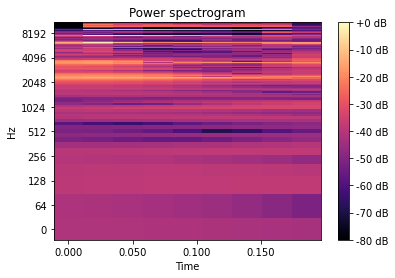

In [69]:
import librosa.display
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.swapaxes(a[0:9], 0, 1),
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()